In [1]:
import os
import sys
threads_num = 2
os.environ["MKL_NUM_THREADS"] = f"{threads_num}" 
os.environ["NUMEXPR_NUM_THREADS"] = f"{threads_num}"
os.environ["OMP_NUM_THREADS"] = f"{threads_num}"
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
import numpy as np
import pandas as pd
import genmodel

from utils import colors, sample_type_to_color, sample_type_to_label, export_legend, transform_model, merge_vdj_alleles, full_js_distance, draw_distances, get_distance_stats_test, draw_pvalues

sns.set_style("ticks")

In [2]:
DATA_DIR = "../data/rubelt_nat_comm/"
SYNTHETIC_DATA_DIR = "../data/human_synthetic_replicates/"
TEST_DATA_DIR = "../data/rubelt_nat_comm_test/"
FIGURES_DIR = "../figures/figure_2/"

In [3]:
sample_types = ["synthetic", "data", "twins", "unrelated"]
sample_sizes = [1000, 3000, 10000, 30000]

# start

In [4]:
def get_distance_stats(n_sequences, exclude):
    run = 1
    main_models = []
    replicate_models = []
    synthetic_replicate_models = []
    n_pairs = 5
    for pair in range(1, n_pairs + 1):
        for twin in ["A", "B"]:
            prefix = os.path.join(DATA_DIR, f"pair_{pair}_twin_{twin}_{n_sequences}_run/main_inference/final")
            model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                      marginals_file=prefix + "_marginals.txt")
            main_models.append(model)
            prefix = os.path.join(DATA_DIR, f"pair_{pair}_twin_{twin}_data_replicate_{n_sequences}_run/main_inference/final")
            model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                      marginals_file=prefix + "_marginals.txt")
            replicate_models.append(model)
    n_synthetic_samples = 30
    for synthetic_id in range(n_synthetic_samples):
        prefix = os.path.join(SYNTHETIC_DATA_DIR, f"synthetic_replicate_{synthetic_id}_{n_sequences}_run/main_inference/final")
        model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                      marginals_file=prefix + "_marginals.txt")
        synthetic_replicate_models.append(model)
            
    n_samples = n_pairs * 2
    if len(main_models) != n_samples or len(replicate_models) != n_samples:
        raise Exception
    transformed_main_models = [merge_vdj_alleles(m) for m in main_models]
    transformed_replicate_models = [merge_vdj_alleles(m) for m in replicate_models]
    transformed_synthetic_replicate_models = [merge_vdj_alleles(m) for m in synthetic_replicate_models]
    keys = {'d_3_del',
             'd_5_del',
             'd_gene',
             'dj_dinucl',
             'dj_ins',
             'j_5_del',
             'j_choice',
             'v_3_del',
             'v_choice',
             'vd_dinucl',
             'vd_ins'}
    data_replicate_distances = [full_js_distance(transformed_main_models[i],
                                                 transformed_replicate_models[i],
                                                 exclude=exclude) \
                                for i in range(n_samples)]
    
    twin_distances = [full_js_distance(transformed_main_models[2*i],
                                       transformed_main_models[2*i+1],
                                       exclude=exclude) \
                      for i in range(n_pairs)]
    twin_distances_2 = [full_js_distance(transformed_replicate_models[2*i],
                                         transformed_replicate_models[2*i+1],
                                         exclude=exclude) \
                        for i in range(n_pairs)]
    twin_distances_3 = [full_js_distance(transformed_main_models[2*i],
                                         transformed_replicate_models[2*i+1],
                                         exclude=exclude) \
                        for i in range(n_pairs)]
    twin_distances_4 = [full_js_distance(transformed_replicate_models[2*i],
                                         transformed_main_models[2*i+1],
                                         exclude=exclude) \
                        for i in range(n_pairs)]
    twin_distances = twin_distances + twin_distances_2 + twin_distances_3 + twin_distances_4
    
    unrelated_distances = [full_js_distance(transformed_main_models[i],
                                            transformed_main_models[k],
                                            exclude=exclude) \
                           for i in range(n_samples) for k in range(i+1, n_samples) if i // 2 != k // 2]
    unrelated_distances_2 = [full_js_distance(transformed_main_models[i],
                                              transformed_replicate_models[k],
                                              exclude=exclude) \
                           for i in range(n_samples) for k in range(n_samples) if i // 2 != k // 2]
    unrelated_distances = unrelated_distances + unrelated_distances_2
    synthetic_distances = [full_js_distance(transformed_synthetic_replicate_models[i],
                                            transformed_synthetic_replicate_models[k],
                                            exclude=exclude) \
                           for i in range(n_synthetic_samples) for k in range(i + 1, n_synthetic_samples)]
    
    return {"synthetic": synthetic_distances,
            "data": data_replicate_distances,
            "twins": twin_distances,
            "unrelated": unrelated_distances}

In [5]:
exclude = []
statistics = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics[n_sequences] = get_distance_stats(n_sequences, exclude)

In [6]:
ylim_explicit = (0, 1.5)
ylim_normalized = (0.5, 6.1)

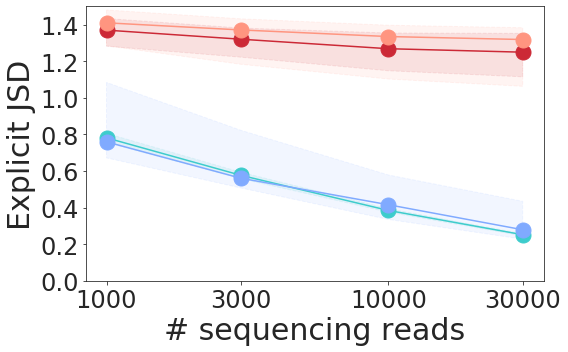

In [7]:
draw_distances(statistics, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_explicit.png"))

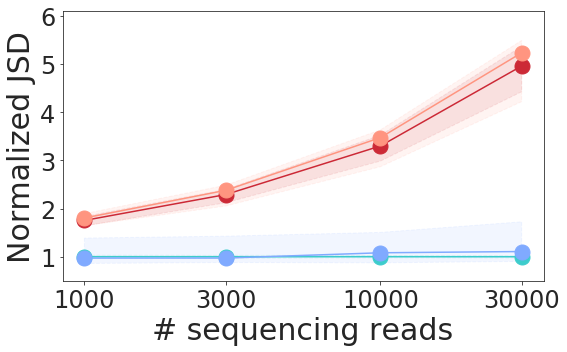

In [8]:
draw_distances(statistics, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_normalized.png"))

In [9]:
for n in [1000, 3000, 10000, 30000]:
    print(np.mean(statistics[n]["twins"]) / np.mean(statistics[n]["unrelated"]))

0.9670544148551753
0.9619778532988047
0.9570386459196961
0.9555292646438184


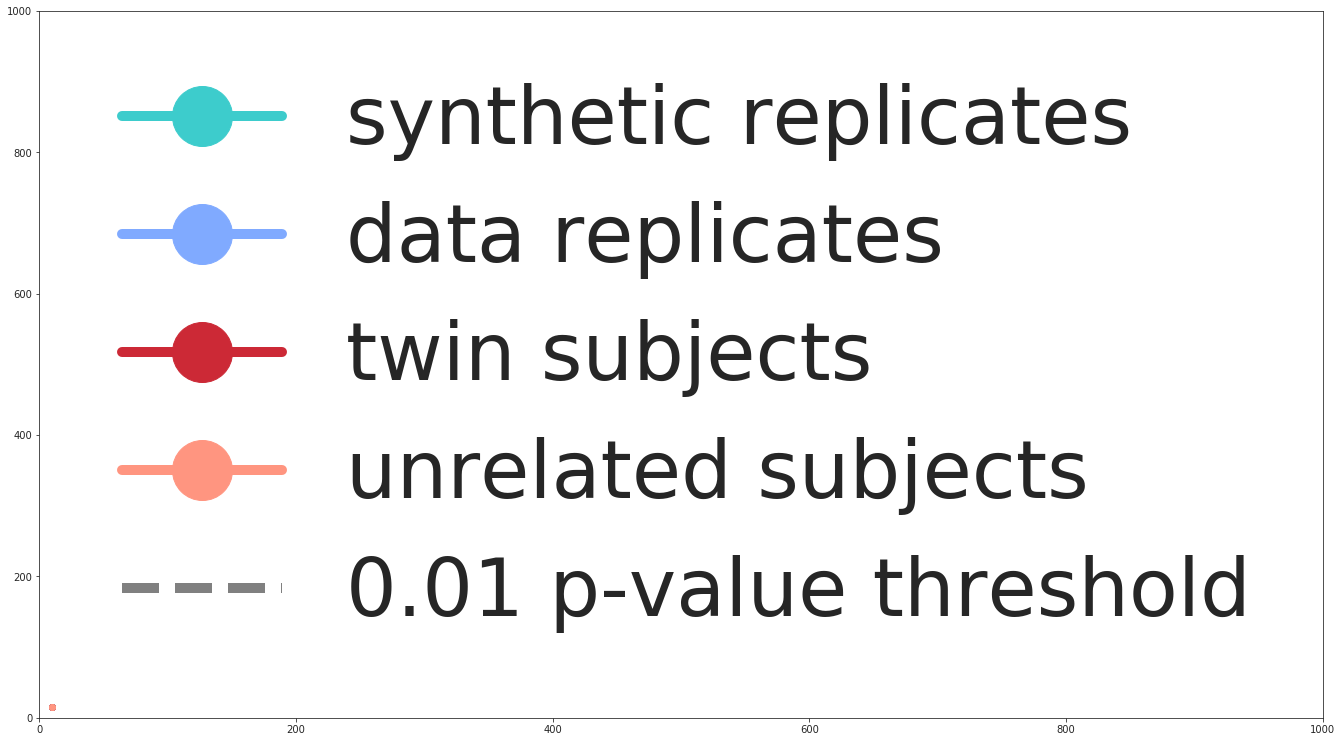

In [10]:
fig = plt.figure(figsize=(23, 13))
fontsize = 25
x = [10, 10]
y = [15, 15]
plt.xlim((0, 1e3))
plt.ylim((0, 1e3))
for sample_type in statistics[1000].keys():
    plt.plot(x, y, color=sample_type_to_color[sample_type], label=sample_type_to_label[sample_type], marker='o')
plt.plot(x, y, color="grey", linestyle="--", label="0.01 p-value threshold")
    
    
sc_coef = 4
leg = plt.legend(fontsize=fontsize * 0.8 * sc_coef, markerscale=2.5 * sc_coef)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5 * sc_coef)
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_rubelt_nat_comm.png"))
plt.show()

In [11]:
test_distances = {}
names = ["data", "twin", "unrelated"]
for n_sequences in sample_sizes:
    test_distances[n_sequences] = {}
    main_distances, other_distances = get_distance_stats_test(TEST_DATA_DIR, n_sequences, names)
    test_distances[n_sequences]["self"] = main_distances
    for name in names:
        test_distances[n_sequences][name] = other_distances[name]
    


In [12]:
pvalues = {}
n_tests = len(sample_sizes) * len(names)
for n_sequences in sample_sizes:
    pvalues[n_sequences] = {}
    for name in names:
        pvalues[n_sequences][name] = scipy.stats.ttest_ind(test_distances[n_sequences]["self"],
                                                           test_distances[n_sequences][name],
                                                           equal_var=False,
                                                           alternative="less").pvalue * n_tests


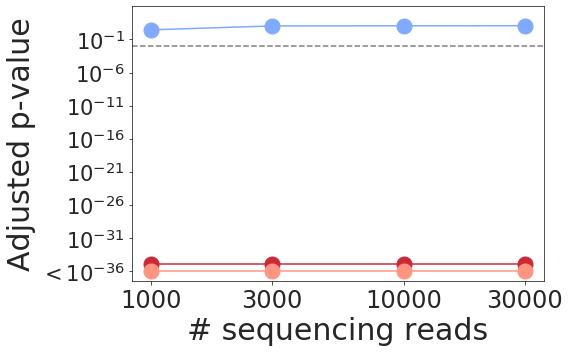

In [13]:
draw_pvalues(pvalues, names, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_pvalue.png"))

# no v

In [14]:
exclude = ["v_delv", "v_d_j"]
statistics_no_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_no_v[n_sequences] = get_distance_stats(n_sequences, exclude)


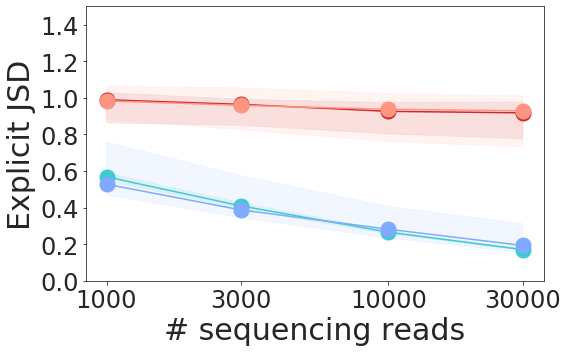

In [15]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_explicit_no_v.png"))

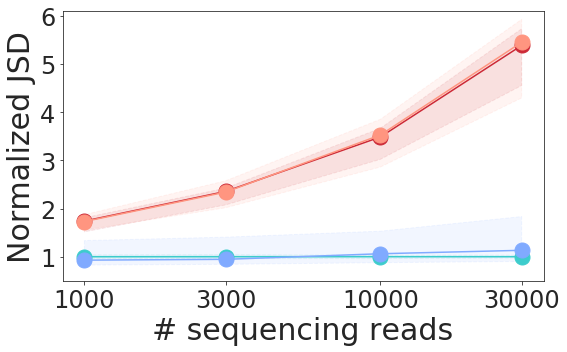

In [16]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_normalized_no_v.png"))

# only v

In [17]:
keys = {'v_delv', 'd_deld', 'dj_ins', 'j_delj', 'v_d_j', 'vd_ins'}

In [18]:
exclude = keys - {"v_delv", "v_d_j"}
statistics_only_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_only_v[n_sequences] = get_distance_stats(n_sequences, exclude)

    


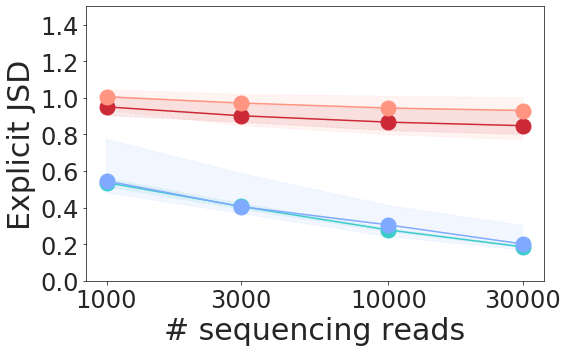

In [19]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_explicit_only_v.png"))

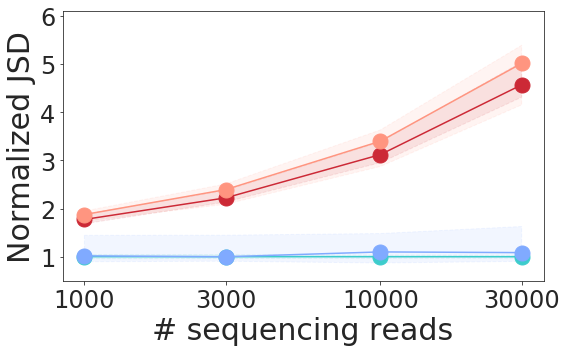

In [20]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "rubelt_nat_comm_normalized_only_v.png"))

# Twins vs Unrelated

In [21]:
n_sequences = 30000
intra_distances = statistics[n_sequences]["twins"]
inter_distances = statistics[n_sequences]["unrelated"]

In [22]:
y = intra_distances + inter_distances
x = ["0"] * len(intra_distances) + ["0"] * len(inter_distances)
hue = ["twins"] * len(intra_distances) + ["unrelated"] * len(inter_distances)
df = pd.DataFrame(np.array([x, y, hue]).T)
df.columns = ["x", "y", "hue"]
df["y"] = df["y"].astype(np.float64)

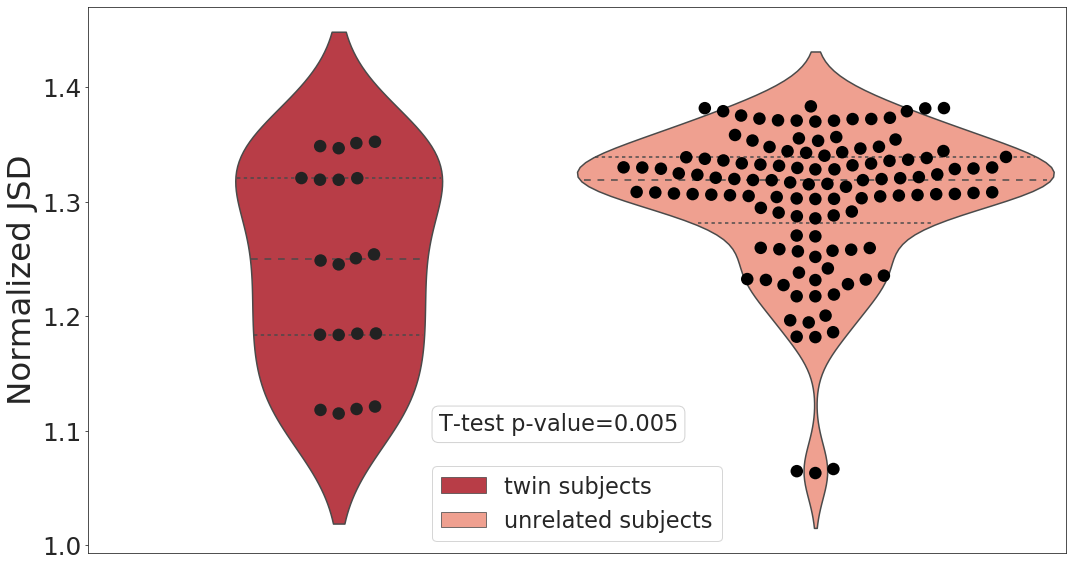

In [23]:
plt.figure(figsize=(15, 8))
fontsize=25

ax = sns.violinplot(x="x", y="y", hue="hue", data=df, 
               scale="area",
               inner="quartile",
               palette=[sample_type_to_color["twins"], sample_type_to_color["unrelated"]])

sns.swarmplot(x="x", y="y", hue="hue", data=df, 
              size=fontsize * 0.5,
              color="black",
              ax=ax,
              dodge=True,
              label='_nolegend_')

ttest_res = scipy.stats.ttest_ind(intra_distances, inter_distances, equal_var=False, alternative="less")

plt.text(s=f"T-test p-value={round(ttest_res.pvalue, 3)}", fontsize=fontsize * 0.9, x=-0.116, y=1.1,
        bbox=dict(facecolor='none', edgecolor='lightgrey', boxstyle='round'))

plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.setp(ax.get_yticklabels(), fontsize=fontsize * 0.99)

plt.xlabel("")
leg = plt.legend(fontsize=fontsize * 0.99, loc="upper center")

leg.legendHandles = leg.legendHandles[:2]
plt.legend(leg.legendHandles, [sample_type_to_label["twins"], sample_type_to_label["unrelated"]],
           fontsize=fontsize * 0.9, loc="lower center")
for legobj in leg.legendHandles:
    if not isinstance(legobj, mpl.patches.Rectangle):
        legobj.set_visible(False)

plt.ylabel("Normalized JSD", fontsize=fontsize * 1.3)

plt.xlim((-0.41, 0.41))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "twins_violinplots.png"), format="png")
plt.show()


In [24]:
for n_sequences in sample_sizes:
    intra_distances = statistics[n_sequences]["twins"]
    inter_distances = statistics[n_sequences]["unrelated"]
    print(np.mean(intra_distances) / np.mean(inter_distances))



0.9670544148551753
0.9619778532988047
0.9570386459196961
0.9555292646438184


In [25]:
n_sequences = 30000
prefix = DATA_DIR 
threshold = 0.01
prefix = os.path.join(DATA_DIR, "pair_{}_twin_{}_30000_run/main_inference/final")
main_models = {pair: [genmodel.GenModel(model_parms_file=prefix.format(pair, twin) + "_parms.txt",
                                         marginals_file=prefix.format(pair, twin) + "_marginals.txt") \
                           for twin in ["A", "B"]] \
                for pair in range(1, 6)}

models_alleles = {pair: [{m.name for m in model.events[0].realizations \
                            if model.marginals[0]["v_choice"][m.index] > threshold} for model in pair_models] \
                      for pair, pair_models in main_models.items()}


for pair in main_models.keys():
    print(f"pair {pair}, allele distance", len(models_alleles[pair][0] ^ models_alleles[pair][1]))


pair 1, allele distance 16
pair 2, allele distance 28
pair 3, allele distance 20
pair 4, allele distance 21
pair 5, allele distance 11
